In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle

import os
import json
import pandas as pd
import utiles 
import utiles_va
from os import listdir
from sklearn.model_selection import train_test_split
import random

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, add, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from tensorflow.keras.applications import VGG16

from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import SmoothingFunction

In [2]:
PATH_COCO_TOKENS = '/home2/data/images/coco2017/annotations'
PATH_FILCKR30k_TOKENS = '/home2/Kacper_captioning/flicker_30k/annotations/captions.txt'
PATH_COCO_IMAGES = '/home2/data/images/coco2017'
PATH_FILCKR30k_IMAGES = '/home2/data/images/flickr30k/Images/flickr30k_images'

PATH_FLICKR8k_IMAGES = '/home2/data/images/flickr8k/Images'
PATH_FILCKR8k_TOKENS = '/home2/data/images/flickr8k/captions.txt'

NUM_WORDS = 10_000
MARK_START = 'ssss'
MARK_END = 'eeee'
SEED = 3
BATCH_SIZE = 128#128 #256
EMBEDDING_SIZE = 256
EPOCHS = 40

In [3]:
path_to_save = '/home2/Kacper_captioning/f8_xception_file_va/'

with open(path_to_save + 'all_caption.pkl', 'rb') as fp:
    captions_all = pickle.load(fp)
with open(path_to_save + 'train_caption.pkl', 'rb') as fp:
    train_captions = pickle.load(fp)
with open(path_to_save + 'test_caption.pkl', 'rb') as fp:
    test_captions = pickle.load(fp)

In [4]:
flat = utiles.flatten(captions_all)
#flat = ' '.join(flat)

tokenizer = utiles.TokenizerWrap(texts=flat, num_words=NUM_WORDS)
token_start = tokenizer.word_index[MARK_START.strip()]
token_end = tokenizer.word_index[MARK_END.strip()]

with open(path_to_save + 'train_images.pkl', 'rb') as fp:
    train_images = pickle.load(fp)

with open(path_to_save + 'test_images.pkl', 'rb') as fp:
    test_images = pickle.load(fp)

shapes = np.load(train_images[list(train_images.keys())[0]]).shape
TRANSFER_VALUE_SIZE = shapes[1]
STATE_SIZE = 512
UNITS = STATE_SIZE
BUFFER_SIZE = 1000
VOCAB_SIZE = NUM_WORDS

CAPTION_LENGTH = 0
for key, value in train_captions.items():
    for inner_list in value:
        if len(inner_list) > CAPTION_LENGTH:
            CAPTION_LENGTH = len(inner_list)

In [5]:
shapes = np.load(train_images[list(train_images.keys())[0]]).shape
features_shape = shapes[2] 
attention_features_shape = shapes[1]

In [6]:
encoder = utiles_va.CNN_Encoder(EMBEDDING_SIZE)
decoder = utiles_va.RNN_Decoder(EMBEDDING_SIZE, UNITS, NUM_WORDS)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

checkpoint_path = '/home2/Kacper_captioning/IM_caption_checkpoint_f8_xception_gru_va_units_512_back_100.keras'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

#load weights
start_epochs = 0
try:
    #start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

2023-07-12 22:52:32.884826: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 22:52:32.890057: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([token_start] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

@tf.function
def validation_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([token_start] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [8]:
# training
captions_dataset_train = []
image_dataset_train = []

def map_func(img_name, cap):
    img_tensor = np.load(img_name)
    img_tensor = np.reshape(img_tensor, [img_tensor.shape[1], img_tensor.shape[2]])
    return img_tensor, cap

train_keys = list(train_images.keys())
for key in train_keys:
    for i in range(len(train_captions[key])):
        image_dataset_train.append(train_images[key])
        captions_dataset_train.append(train_captions[key][i])

tokens_padded = pad_sequences(captions_dataset_train, maxlen=CAPTION_LENGTH, padding='post',truncating='post')

dataset = tf.data.Dataset.from_tensor_slices((image_dataset_train, tokens_padded))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# validation
captions_dataset_val = []
image_dataset_val = []

test_keys = list(test_images.keys())

for key in test_keys:
    for i in range(len(test_captions[key])):
        image_dataset_val.append(test_images[key])
        captions_dataset_val.append(test_captions[key][i])

tokens_padded_val = pad_sequences(captions_dataset_val, maxlen=CAPTION_LENGTH, padding='post',truncating='post')

dataset_val = tf.data.Dataset.from_tensor_slices((image_dataset_val, tokens_padded_val))

# Use map to load the numpy files in parallel
dataset_val = dataset_val.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset_val = dataset_val.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)

num_steps_train = len(image_dataset_train) // BATCH_SIZE
num_steps_val = len(image_dataset_val) // BATCH_SIZE

In [9]:
%%time
loss_plot = []
val_loss_plot = []

print('Start learning')
for epoch in range(0, 100):
    total_loss = 0
    total_loss_vall = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor.numpy(), target.numpy())
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps_train)
    
    for (batch_val, (img_tensor, target)) in enumerate(dataset):
        batch_val_loss, val_loss = validation_step(img_tensor, target)
        total_loss_vall += val_loss
    val_loss_plot.append(total_loss_vall / num_steps_val)
    
    # save model after each run
    ckpt_manager.save()
    
    print(f'Epoch {epoch+1} Loss train {total_loss/num_steps_train:.6f} Loss val {total_loss_vall/num_steps_val:.6f}')
    #print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Start learning
Epoch 1 Batch 0 Loss 2.6734
Epoch 1 Batch 100 Loss 1.5894
Epoch 1 Batch 200 Loss 1.4331
Epoch 1 Loss train 1.569062 Loss val 3.962380
Epoch 2 Batch 0 Loss 1.5091
Epoch 2 Batch 100 Loss 1.3078
Epoch 2 Batch 200 Loss 1.1282
Epoch 2 Loss train 1.207963 Loss val 3.319160
Epoch 3 Batch 0 Loss 1.0698
Epoch 3 Batch 100 Loss 1.0154
Epoch 3 Batch 200 Loss 1.0941
Epoch 3 Loss train 1.061322 Loss val 2.982822
Epoch 4 Batch 0 Loss 1.0349
Epoch 4 Batch 100 Loss 1.0479
Epoch 4 Batch 200 Loss 0.9324
Epoch 4 Loss train 0.972012 Loss val 2.760356
Epoch 5 Batch 0 Loss 0.9290
Epoch 5 Batch 100 Loss 0.8858
Epoch 5 Batch 200 Loss 0.9012
Epoch 5 Loss train 0.902266 Loss val 2.588561
Epoch 6 Batch 0 Loss 0.9135
Epoch 6 Batch 100 Loss 0.7951
Epoch 6 Batch 200 Loss 0.8739
Epoch 6 Loss train 0.842883 Loss val 2.439806
Epoch 7 Batch 0 Loss 0.8128
Epoch 7 Batch 100 Loss 0.7693
Epoch 7 Batch 200 Loss 0.8065
Epoch 7 Loss train 0.793618 Loss val 2.346324
Epoch 8 Batch 0 Loss 0.8204
Epoch 8 Batch 100 L

Epoch 60 Loss train 0.209362 Loss val 1.213857
Epoch 61 Batch 0 Loss 0.2291
Epoch 61 Batch 100 Loss 0.2034
Epoch 61 Batch 200 Loss 0.1909
Epoch 61 Loss train 0.206511 Loss val 1.235025
Epoch 62 Batch 0 Loss 0.1844
Epoch 62 Batch 100 Loss 0.1939
Epoch 62 Batch 200 Loss 0.1869
Epoch 62 Loss train 0.207685 Loss val 1.230956
Epoch 63 Batch 0 Loss 0.2084
Epoch 63 Batch 100 Loss 0.1985
Epoch 63 Batch 200 Loss 0.2131
Epoch 63 Loss train 0.207320 Loss val 1.198919
Epoch 64 Batch 0 Loss 0.1955
Epoch 64 Batch 100 Loss 0.2033
Epoch 64 Batch 200 Loss 0.1872
Epoch 64 Loss train 0.201368 Loss val 1.240959
Epoch 65 Batch 0 Loss 0.1947
Epoch 65 Batch 100 Loss 0.1967
Epoch 65 Batch 200 Loss 0.2096
Epoch 65 Loss train 0.212680 Loss val 1.228116
Epoch 66 Batch 0 Loss 0.1981
Epoch 66 Batch 100 Loss 0.2109
Epoch 66 Batch 200 Loss 0.2259
Epoch 66 Loss train 0.216316 Loss val 1.211239
Epoch 67 Batch 0 Loss 0.1893
Epoch 67 Batch 100 Loss 0.1796
Epoch 67 Batch 200 Loss 0.1963
Epoch 67 Loss train 0.201423 Loss 

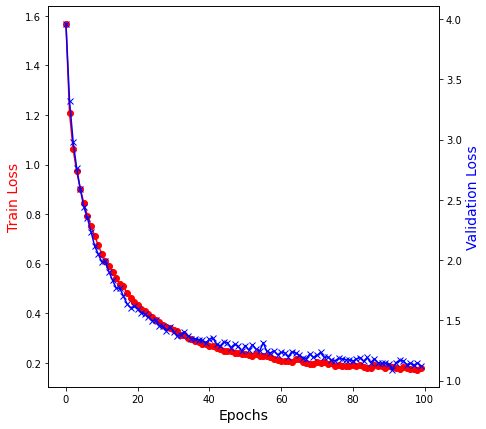

In [10]:
fig,ax = plt.subplots(figsize = (7,7))
# make a plot
ax.plot(loss_plot, color="red", marker="o")
# set x-axis label
ax.set_xlabel("Epochs", fontsize = 14)
# set y-axis label
ax.set_ylabel("Train Loss", color="red", fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(val_loss_plot, color="blue", marker="x")
ax2.set_ylabel("Validation Loss", color="blue", fontsize=14)
plt.show()

In [11]:
bleu_1_train = []; bleu_2_train = []; bleu_3_train = []; bleu_4_train = []
meteor_train = []
rouge_1_train = []; rouge_2_train = []; rouge_L_train = []
cider_train = []
scorer_rouge = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
chencherry = SmoothingFunction()

image_dataset_train_numpy = np.array(image_dataset_train)
captions_dataset_train_numpy = np.array(captions_dataset_train)
images = set(image_dataset_train)

train_prediction = {}
counter = 0
for element in images:
    utiles.print_progress(counter, len(images))

    index = np.where(image_dataset_train_numpy == element)
    # data
    image_val = np.load(element)
    reference_captions = captions_dataset_train_numpy[index]
    caption_val_raw = []
    caption_val_split = []
    for el in reference_captions: 
        cap = tokenizer.tokens_to_string(el[1:-1])
        caption_val_raw.append(cap)
        caption_val_split.append(cap.split())
    
    # make prediction
    hidden = decoder.reset_state(batch_size=1)
    features = encoder(image_val)
    dec_input = tf.expand_dims([tokenizer.word_index[MARK_END.strip()]], 0)
    prediction_caption = []

    for i in range(CAPTION_LENGTH):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(tokenizer.index_to_word[predicted_id])
        prediction_caption.append(predicted_word)

        if predicted_word == MARK_END:
            prediction_caption = prediction_caption[:-1]
            break
            
        dec_input = tf.expand_dims([predicted_id], 0)

    # calculate matrics
    # Calculate BLEU-1 score
    bleu_1_train.append(sentence_bleu(caption_val_split, prediction_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-2 score
    bleu_2_train.append(sentence_bleu(caption_val_split, prediction_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-3 score
    bleu_3_train.append(sentence_bleu(caption_val_split, prediction_caption, weights=(1/3, 1/3, 1/3, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-4 score
    bleu_4_train.append(sentence_bleu(caption_val_split, prediction_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1))
    # calculate Meteor
    meteor_train.append(meteor_score(caption_val_split, prediction_caption))
    # rouge score
    for el in caption_val_raw:
        rouge_scores = scorer_rouge.score(el, ' '.join(prediction_caption))
        rouge_1_train.append(rouge_scores['rouge1'].fmeasure)
        rouge_2_train.append(rouge_scores['rouge2'].fmeasure)
        rouge_L_train.append(rouge_scores['rougeL'].fmeasure)

    counter += 1
    key_img = element.split('/')[-1][:-4]
    train_prediction[key_img] =  ' '.join(prediction_caption)

print("#"*20)
print("\tMetrics train set")
print("BLEU-1: ", np.round(np.mean(bleu_1_train),2), '+-', np.round(np.std(bleu_1_train),2))
print("BLEU-2: ", np.round(np.mean(bleu_2_train),2), '+-', np.round(np.std(bleu_2_train),2))
print("BLEU-3: ", np.round(np.mean(bleu_3_train),2), '+-', np.round(np.std(bleu_3_train),2))
print("BLEU-4: ", np.round(np.mean(bleu_4_train),2), '+-', np.round(np.std(bleu_4_train),2))
print("METEOR: ", np.round(np.mean(meteor_train),2), '+-', np.round(np.std(meteor_train),2))
print("ROUGE-1: ", np.round(np.mean(rouge_1_train),2), '+-', np.round(np.std(rouge_1_train),2))
print("ROUGE-2: ", np.round(np.mean(rouge_2_train),2), '+-', np.round(np.std(rouge_2_train),2))
print("ROUGE-L: ", np.round(np.mean(rouge_L_train),2), '+-', np.round(np.std(rouge_L_train),2))

# metrics calculation for validation set
cider_val = []
bleu_1_val = []; bleu_2_val = []; bleu_3_val = []; bleu_4_val = []
meteor_val = []
rouge_1_val = []; rouge_2_val = []; rouge_L_val = []
scorer_rouge = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
chencherry = SmoothingFunction()

image_dataset_val_numpy = np.array(image_dataset_val)
captions_dataset_val_numpy = np.array(captions_dataset_val)
images = set(image_dataset_val)

val_prediction = {}
counter = 0
for element in images:
    utiles.print_progress(counter, len(images))

    index = np.where(image_dataset_val_numpy == element)
    # data
    image_val = np.load(element)
    reference_captions = captions_dataset_val_numpy[index]
    caption_val_raw = []
    caption_val_split = []
    for el in reference_captions: 
        cap = tokenizer.tokens_to_string(el[1:-1])
        caption_val_raw.append(cap)
        caption_val_split.append(cap.split())
    
    # make prediction
    hidden = decoder.reset_state(batch_size=1)
    features = encoder(image_val)
    dec_input = tf.expand_dims([tokenizer.word_index[MARK_END.strip()]], 0)
    prediction_caption = []

    for i in range(CAPTION_LENGTH):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(tokenizer.index_to_word[predicted_id])
        prediction_caption.append(predicted_word)

        if predicted_word == MARK_END:
            prediction_caption = prediction_caption[:-1]
            break
            
        dec_input = tf.expand_dims([predicted_id], 0)

    # calculate matrics
    # Calculate BLEU-1 score
    bleu_1_val.append(sentence_bleu(caption_val_split, prediction_caption, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-2 score
    bleu_2_val.append(sentence_bleu(caption_val_split, prediction_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-3 score
    bleu_3_val.append(sentence_bleu(caption_val_split, prediction_caption, weights=(1/3, 1/3, 1/3, 0), smoothing_function=chencherry.method1))
    # Calculate BLEU-4 score
    bleu_4_val.append(sentence_bleu(caption_val_split, prediction_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1))
    # calculate Meteor
    meteor_val.append(meteor_score(caption_val_split, prediction_caption))
    # rouge score
    for el in caption_val_raw:
        rouge_scores = scorer_rouge.score(el, ' '.join(prediction_caption))
        rouge_1_val.append(rouge_scores['rouge1'].fmeasure)
        rouge_2_val.append(rouge_scores['rouge2'].fmeasure)
        rouge_L_val.append(rouge_scores['rougeL'].fmeasure)
    
    key_img = element.split('/')[-1][:-4]
    val_prediction[key_img] =  ' '.join(prediction_caption)
    counter +=1
 
print("#"*20)
print("\tMetrics val set")
print("BLEU-1: ", np.round(np.mean(bleu_1_val),2), '+-', np.round(np.std(bleu_1_val),2))
print("BLEU-2: ", np.round(np.mean(bleu_2_val),2), '+-', np.round(np.std(bleu_2_val),2))
print("BLEU-3: ", np.round(np.mean(bleu_3_val),2), '+-', np.round(np.std(bleu_3_val),2))
print("BLEU-4: ", np.round(np.mean(bleu_4_val),2), '+-', np.round(np.std(bleu_4_val),2))
print("METEOR: ", np.round(np.mean(meteor_val),2), '+-', np.round(np.std(meteor_val),2))
print("ROUGE-1: ", np.round(np.mean(rouge_1_val),2), '+-', np.round(np.std(rouge_1_val),2))
print("ROUGE-2: ", np.round(np.mean(rouge_2_val),2), '+-', np.round(np.std(rouge_2_val),2))
print("ROUGE-L: ", np.round(np.mean(rouge_L_val),2), '+-', np.round(np.std(rouge_L_val),2))
                                          
path_to_save = '/home2/Kacper_captioning/f30_xception_file_va/'

with open(path_to_save + 'train_predictions_units_512_v2.pkl', 'wb') as fp:
    pickle.dump(train_prediction, fp)
with open(path_to_save + 'test_predictions_units_512_v2.pkl', 'wb') as fp:
    pickle.dump(val_prediction, fp)

- Progress: 0.0%

/home/mateusz/anaconda3/envs/framework/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


- Progress: 100.0%####################
	Metrics train set
BLEU-1:  0.56 +- 0.27
BLEU-2:  0.44 +- 0.29
BLEU-3:  0.35 +- 0.3
BLEU-4:  0.28 +- 0.28
METEOR:  0.44 +- 0.25
ROUGE-1:  0.28 +- 0.21
ROUGE-2:  0.11 +- 0.19
ROUGE-L:  0.27 +- 0.21
- Progress: 0.0%

/home/mateusz/anaconda3/envs/framework/lib/python3.7/site-packages/ipykernel_launcher.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


- Progress: 100.0%####################
	Metrics val set
BLEU-1:  0.29 +- 0.2
BLEU-2:  0.13 +- 0.15
BLEU-3:  0.08 +- 0.1
BLEU-4:  0.06 +- 0.07
METEOR:  0.2 +- 0.16
ROUGE-1:  0.15 +- 0.14
ROUGE-2:  0.03 +- 0.07
ROUGE-L:  0.14 +- 0.14
